In [1]:
from collections import OrderedDict
import pickle

from ml_pee_stego_v3 import MLPEEStego
from pee_stego_v4 import PEEStego

## Patient Data

In [2]:
from utils.data_preparation import get_original_data

patient_code = '100'
original_data = get_original_data(patient_code=patient_code)
len(original_data)

3600

## Secret File

In [3]:
from utils.data_preparation import get_secret_file

secret_filenames = ['secret_0.99_bps']

# Tentukan folder path tempat secret
SECRET_FOLDER_PATH = 'keys/bin'

# Masukkan ke dalam dictionary berisi nama filename beserta isi secret filenya
secret_dicts = OrderedDict((secret_filename, get_secret_file(
    SECRET_FOLDER_PATH + '/' + secret_filename + '.txt')) for secret_filename in secret_filenames)
# print(secret_dicts.get(secret_filenames[1]))

for secret_name, secret_data in secret_dicts.items():
    print(f"Secret untuk {secret_name}")

Secret untuk secret_0.99_bps


## Payload and Treshold

In [4]:
pr_n_t = [(1, 0), (3, 1)]

## Model V4

In [5]:
import warnings
from sklearn.exceptions import InconsistentVersionWarning

# Menonaktifkan peringatan InconsistentVersionWarning
warnings.simplefilter("ignore", category=InconsistentVersionWarning)

models = OrderedDict()

models['LASSO'] = 'models/lasso_model.pkl'

## Run

By secret

Secret[0]: secret_0.99_bps	0: pr(1) t(0)
[-145 -145 -145 -145 -145 -145 -145 -145 -119 -134]
Total yang kurang dari sama dengan threshold (T = 1): 598
Unhidden secret: 0
NCC: 0.9999928410383981
PRD: 0.17776591124822136
SNR: 55.00303033145307
PSNR: 31.73699339312499
Time: 2.37064528465271
[-145 -145 -145 -145 -145 -145 -146 -146 -119 -134]
Total yang kurang dari sama dengan threshold (T = 1): 491
Unhidden secret: 0
NCC: 0.9999925645340758
PRD: 0.18263711209151268
SNR: 54.768219372957844
PSNR: 31.619587913877375
Time: 0.18501973152160645
Axes(0.55125,0.705;0.3255x0.1645)
Secret[0]: secret_0.99_bps	1: pr(3) t(1)
True
[-145 -145 -145 -145 -145 -145 -145 -145 -120 -136]
Total yang kurang dari sama dengan threshold (T = 1): 348
Unhidden secret: 0
NCC: 0.9999354743568334
PRD: 0.5337140242051783
SNR: 45.45382770503372
PSNR: 26.97592854225817
Time: 0.8941671848297119
[-145 -145 -145 -145 -145 -145 -146 -145 -113 -134]
Total yang kurang dari sama dengan threshold (T = 1): 244
Unhidden secret: 0


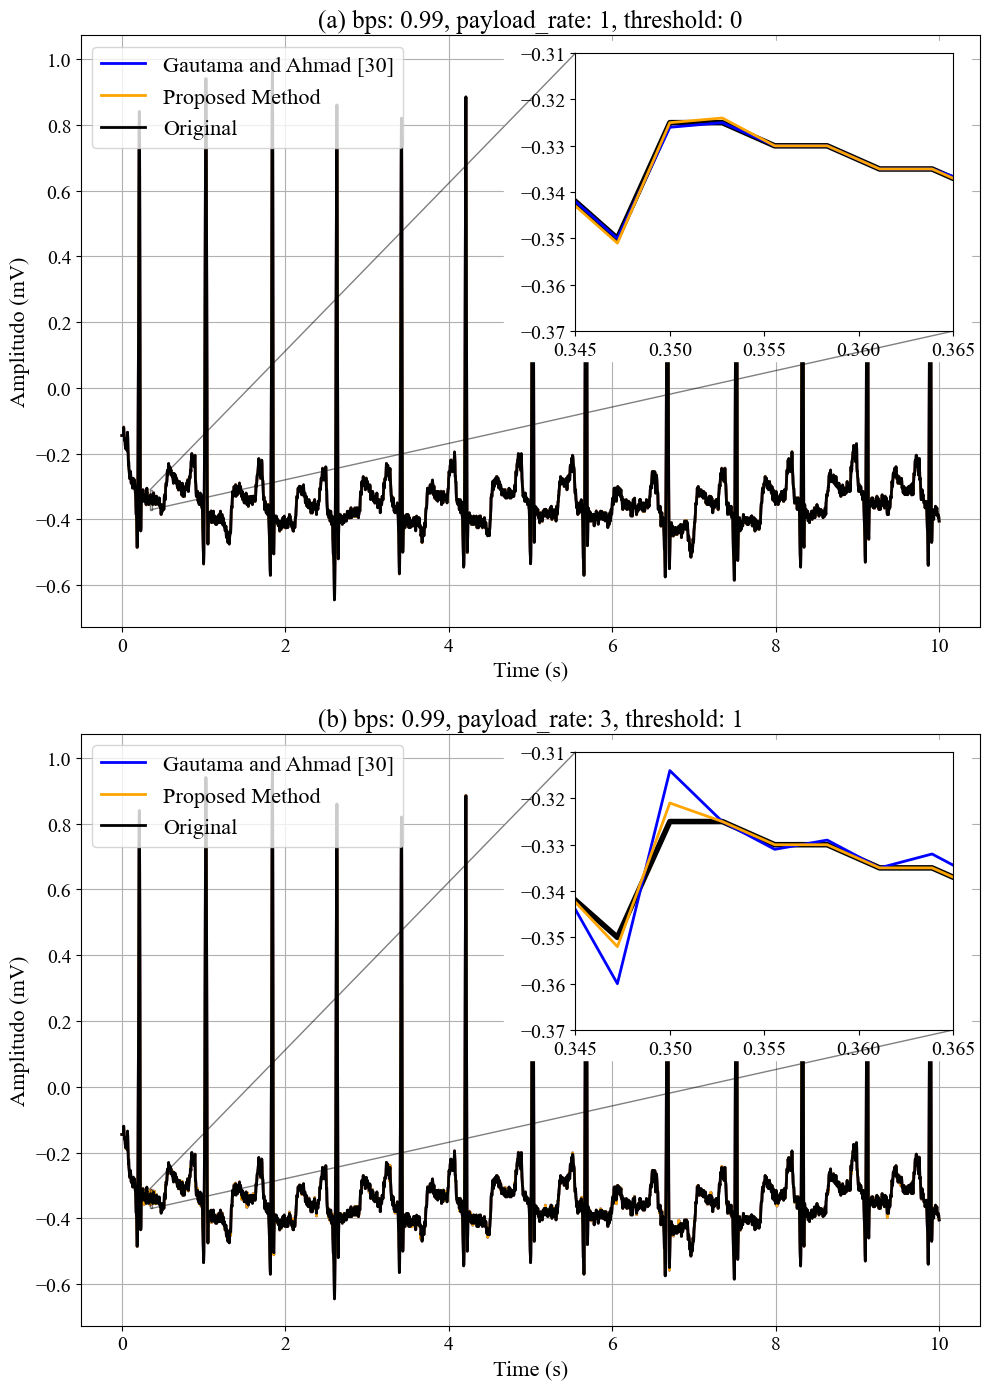

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes, mark_inset

# Stego V3
model_name = 'LASSO'
with open(models.get(model_name), 'rb') as model_file:
    model = pickle.load(model_file)
stego_v3 = MLPEEStego(model)

# Stego V4
stego_v4 = PEEStego()

plt.rcParams['font.family'] = 'Times New Roman'
fig, axs = plt.subplots(len(pr_n_t), len(secret_dicts), figsize=(10, 14))
names = ['a', 'b']

fs = 360
y = np.arange(len(original_data)) / fs

secret_index = 0
for secret_name, secret_data in secret_dicts.items():
    for pr_n_t_index, (payload_rate, threshold) in enumerate(pr_n_t):
        print(f'Secret[{secret_index}]: {secret_name}\t{pr_n_t_index}: pr({payload_rate}) t({threshold})')
        watermarked_data_v3, _, _, _, _, result_v3 = stego_v3.embed(
            original_data, secret_data, payload_rate=payload_rate, threshold=threshold)
        watermarked_data_v4, _, _, _, _, result_v4 = stego_v4.embed(
            original_data, secret_data, payload_rate=payload_rate, threshold=threshold)

        axs[pr_n_t_index].plot(
            y, watermarked_data_v3/1000, label='Gautama and Ahmad [30]', color='blue', linewidth=2)
        axs[pr_n_t_index].plot(
            y, watermarked_data_v3/1000, label='Proposed Method', color='orange', linewidth=2)
        axs[pr_n_t_index].plot(y, original_data/1000, label='Original', color='black', linewidth=2)
        
        axs[pr_n_t_index].set_xlabel('Time (s)', fontsize=16)
        axs[pr_n_t_index].set_ylabel(
            'Amplitudo (mV)', fontsize=16)
        axs[pr_n_t_index].set_title(
            f'({names[pr_n_t_index]}) bps: {secret_name[7:11]}, payload_rate: {payload_rate}, threshold: {threshold}', 
            fontsize=18)
        axs[pr_n_t_index].grid(True)
        axs[pr_n_t_index].legend(loc='upper left', fontsize=16)
        axs[pr_n_t_index].tick_params(axis='both', labelsize=14)

        # Add white rectangle behind inset_axes
        rect = patches.Rectangle(
            (0.47, 0.45), 0.52, 0.54, transform=axs[pr_n_t_index].transAxes, color='white', zorder=4)
        axs[pr_n_t_index].add_patch(rect)

        # Buat sumbu tambahan yang diperbesar
        # axins = axs[pr_n_t_index].inset_axes(
        #     [0., -0.7, 0.5, 0.5],
        #     xlim=(0.35, 0.37), ylim=(-0.34, -0.32))
        axins = axs[pr_n_t_index].inset_axes([0.55, 0.5, 0.42, 0.47])
        axins.plot(y, original_data/1000, linewidth=4, color='black')
        axins.plot(y, watermarked_data_v3/1000, linewidth=2, color='blue')
        axins.plot(y, watermarked_data_v4/1000, linewidth=2, color='orange')
        
        axins.set_xlim(0.345, 0.365)
        axins.set_ylim(-0.37, -0.31)
        axins.tick_params(axis='both', labelsize=14)

        axins.patch.set_facecolor('white')  # make outside area white
        axins.patch.set_alpha(1.0)  # Ensure the patch is fully opaque

        print(axins)
        axs[pr_n_t_index].indicate_inset_zoom(axins, edgecolor="black")

fig.tight_layout(h_pad=2)
plt.savefig('out/v4_4_signal_comparison.png', dpi=300)
plt.show()